<a href="https://colab.research.google.com/github/zulylapa/GEOS_518_LAPA/blob/main/mod05_1D_Advection_Assignment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 04: Advection Dominated Systems Assignment
## Name: Zuly Lapa

## Overview and Requirements

___DISASTER!___ An earthquake has resulted in a partial meltdown of a nuclear reactor and the contamination of that reactor's cooling water tanks. The reactor automatically scrammed and the reactor hall was safe enough that the fuel rods were removed, but not before a significant leak of radioactive Cesium into the water stored in the tanks. Cs-137 is highly soluble in water and so the whole tank is effectively uniformly contaminated. What's worse, the earthquake also ruptured the cooling water tanks and contaminated water is now leaking into the aquifer. The location of the rupture is such that it is too dangerous to repair.

Your job as a consultant is to conduct a "worst case" scenario modeling study in which the tank will continue to drain contaminated water into the aquifer at a constant rate of 0.05% of its volume per year. The aquifer is an unconfined aquifer that has a saturated hydraulic conductivity ($K_s$) of 15.0 cm/day and a constant regional head gradient $\partial h/\partial t$ of 30.0 ft/mile.

Using your trusy advection-dominated code your wrote as a graduate student at Boise State, you know you can simply modify the boundary conditions to your model to examine the impact. Your solution notebook you turn in should have code that produces the following plots:

* The concentration of the contaminant of the aquifer at the contamination site
* Concentration profiles (concentration vs. distance) at every 50th time step of the simulation
* The plot showing the evolution of concentration as a function of both distance from the contamination site and time
* The breakthrough curve (concentration vs. time) at a location x = 1500 m

Answer the following questions:
* What time step did you have to select to get the Courant number as close to 1.0 as possible? <font color="red">The time step that was used to get a Courant number as close to 1 was going to be dt=16, but to be evenly distributed, I used dt=15.</font>
* If you were to have to describe what was going to happen to the water quality at the town located 1.5 km from the contamination site, how would you describe in words how the water quality will behave in the future? <font color="red">For folks located 1.5km from the contamination, it is forecasted that the concentration levels will spike up between the years 4300 and 5000 and slowly decrease. The concentration levels is predicted to increase to about 0.9 GBq/g.</font>
* If concentrations below 0.05 GBq/g are considered safe for drinking water quallity, at the town 1.5 km away from the contamination site, how many years in the future will it take the contamination plume to arrive? And how long will the water be unusable? <font color="red">If concentrations below 0.05 GBq/G is considered safe for drinking water quality, then the town located 1.5 km away from the contamination site will see a rise in concentration at year 4300. The water will then be unusable for approximately 5700 years.</font>


In [124]:
import numpy as np
import matplotlib.pyplot as plt

dx = 5.0  # Spatial interval [m] - DON'T CHANGE
dt = 15 # Time step [yr]

# Fraction of initial tank volume lost each year [yr-1]
k_tank = 0.0005

xmin = 0.0 # Origin: Contamination site
xmax = 4000.0 # Edge of the domain

t0 = 0.0 # Time that the tank broke

# I originally had 10000 for tf, so I wasn't able to accurately solve the third question for how long the water would be unusable.
tf = 15000.0 # End of simulation time

Ks = 15.0 # Saturated hydraylic conductivity [cm/day]
dhdx = 30.0 # Regional piezometric gradient [ft/mi]

Ks = Ks/100.0*365.25 # Converting Ks from [cm/day] to [m/yr]
dhdx = dhdx*(1/5280.0)

In [125]:
q = Ks*dhdx

print('The Darcy velocity is ' + '{:.3f}'.format(q) + ' [m/yr]')

The Darcy velocity is 0.311 [m/yr]


Set up the Spatial Domain

In [126]:
x = np.arange(xmin+dx/2, xmax, dx)
Nx = x.size

print('The number of cells is: Nx = ' + str(Nx))

The number of cells is: Nx = 800


Set up the Time Vector

In [127]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('The number of time steps: Nt = ' + str(Nt))

The number of time steps: Nt = 1001


In [128]:
Courant = q*(dt/dx)

print('The Courant number is ' + '{:.3f}'.format(Courant)+'. The optimal number is 1 to avoid numerical diffusion. Consider changing dt')

The Courant number is 0.934. The optimal number is 1 to avoid numerical diffusion. Consider changing dt


### Setup Initial and Boundary Conditions

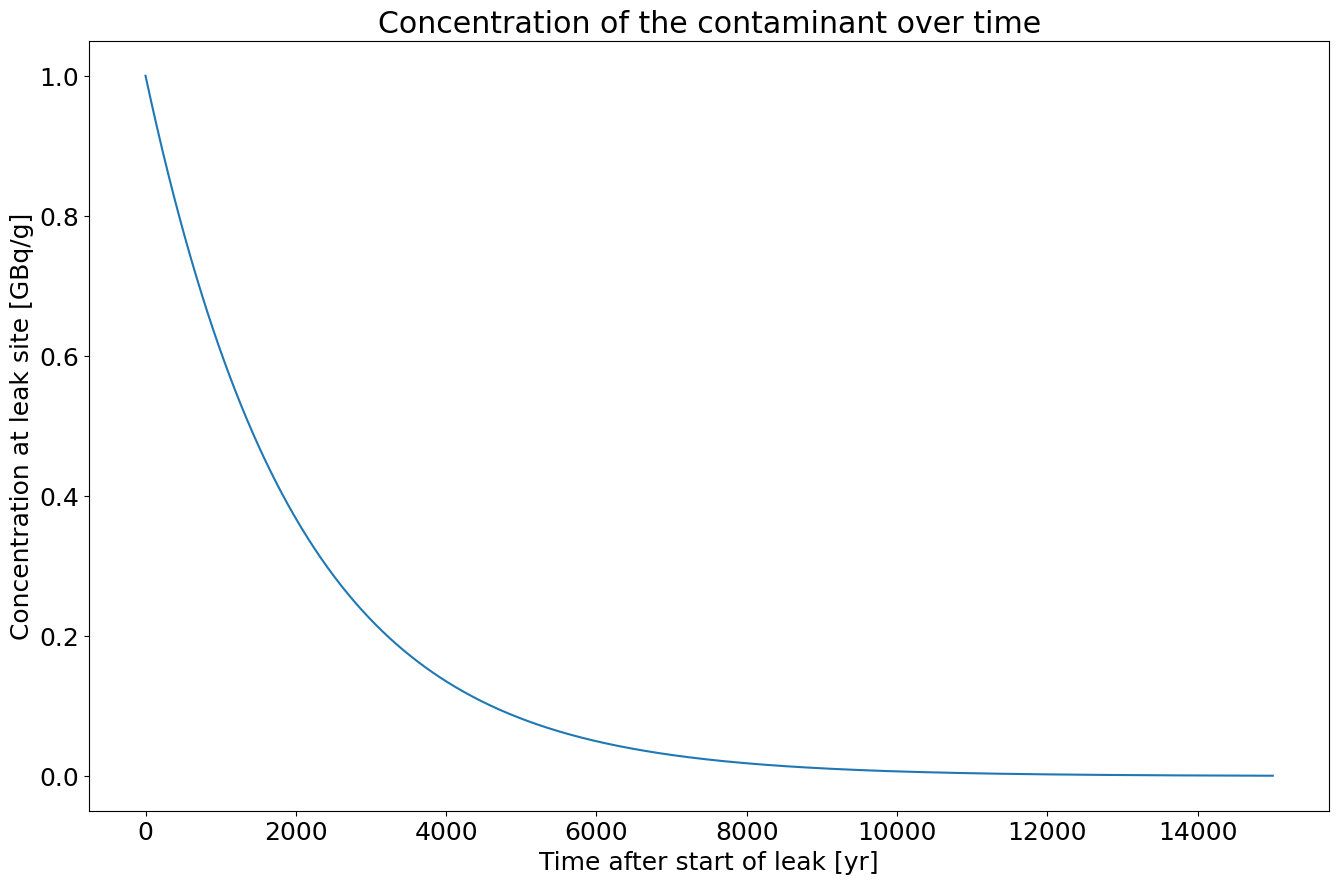

In [129]:
# Initial condition: concentration is 0 GBq/g everywhere except at x = 0,
# where it is 1 Bq/g
c0 = np.zeros((Nx,1))
c0[0] = 1


# Boundary condition: concentration decreases at a rate of k_tank [yr-1]
# To represent concentration decay, the mathematical representation is an
# exponential. Ex. C(t) = C_o * exp (-kt). I had trouble figuring this out, so I
# used Copilot.
csource = c0[0]*np.exp(-k_tank*t)

# The concentration of the contaminant of the aquifer at the contamination
# site.
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})
plt.plot(t,csource)
plt.title('Concentration of the contaminant over time')
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at leak site [GBq/g]')
plt.show()

### Preallocate Container for Solution

In [130]:
C = np.zeros((Nx,Nt))


### Compute Solution

In [131]:
for i in np.arange(Nt):

    # Get initial conditions
    if (i==0):
        Cprev = c0
    else:
        Cprev = C[:,i-1]

    Cnext = np.zeros((Nx))

    for j in np.arange(Nx):

        if (j==0):
          Cnext[0] = csource[i]
        else:
          Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1]-Cprev[j])


    C[:,i] = Cnext

<ipython-input-131-8e1282248cbf>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1]-Cprev[j])


### Plot solutions

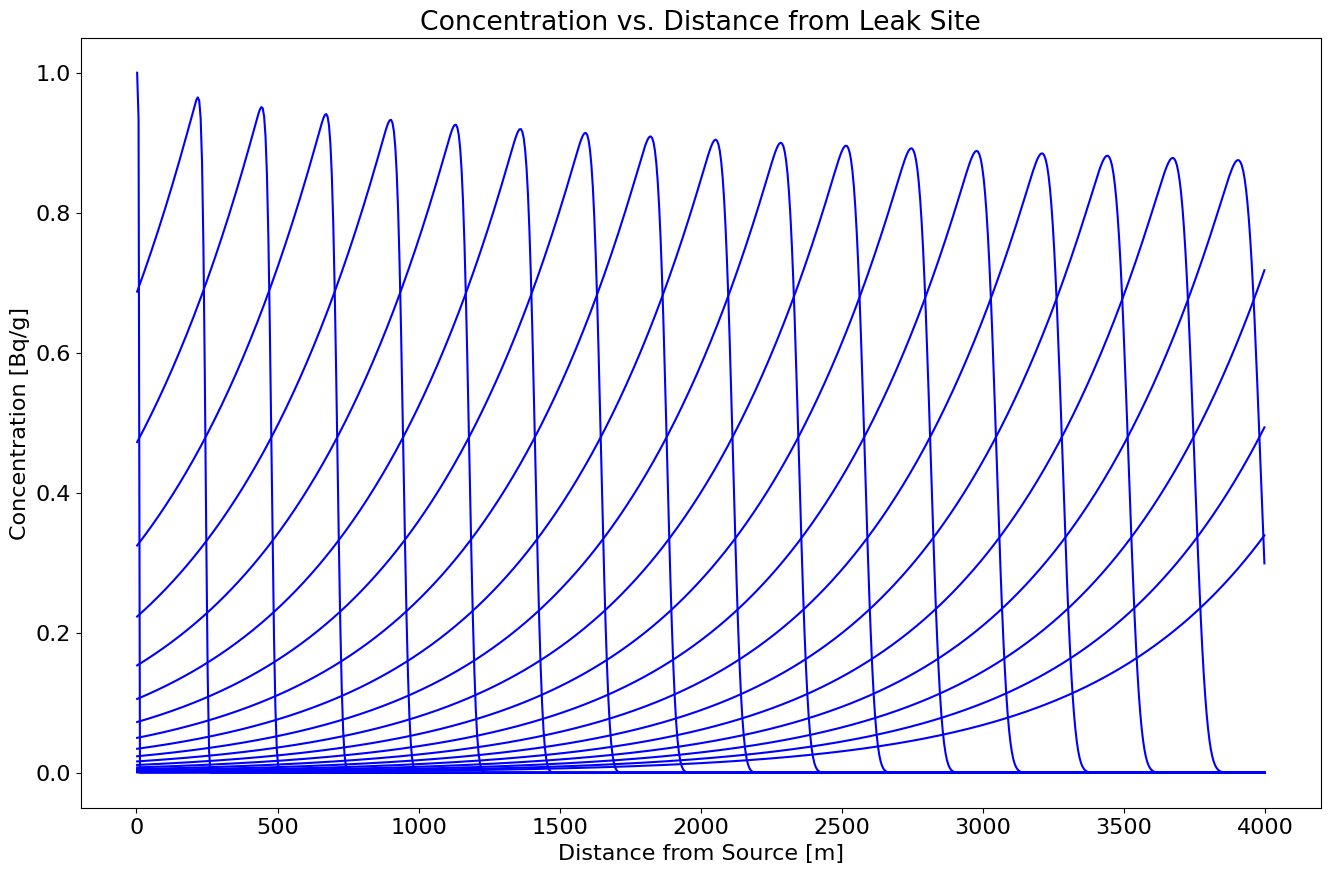

In [132]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))

# Plot every 50th concentration curve
for p in np.arange(0,Nt,50):
    plt.plot(x,C[:,p],'b')

plt.title('Concentration vs. Distance from Leak Site')
plt.ylabel('Concentration [Bq/g]')
plt.xlabel('Distance from Source [m]')
plt.show()

Text(0, 0.5, 'Time [years]')

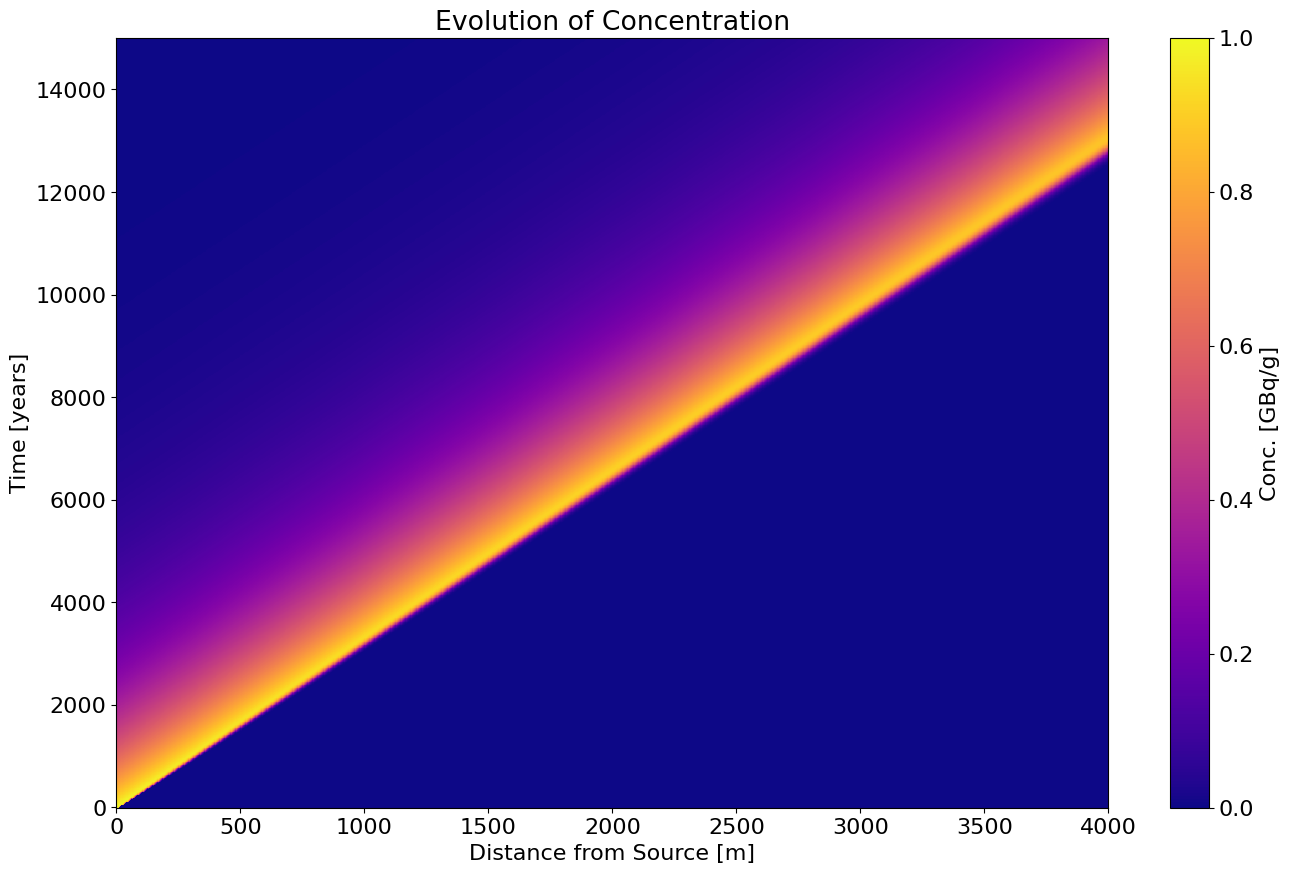

In [133]:
xx,tt = np.meshgrid(t,x)

plt.figure(figsize=(16,10))

plt.pcolormesh(tt,xx,C,cmap='plasma') #Fixed this after turning in the assignment. I had it (xx,tt,...)
plt.colorbar(label='Conc. [GBq/g]')
plt.title('Evolution of Concentration')
plt.xlabel('Distance from Source [m]')
plt.ylabel('Time [years]')


The breakthrough curve (concentration vs. time) at a location x = 1500 m

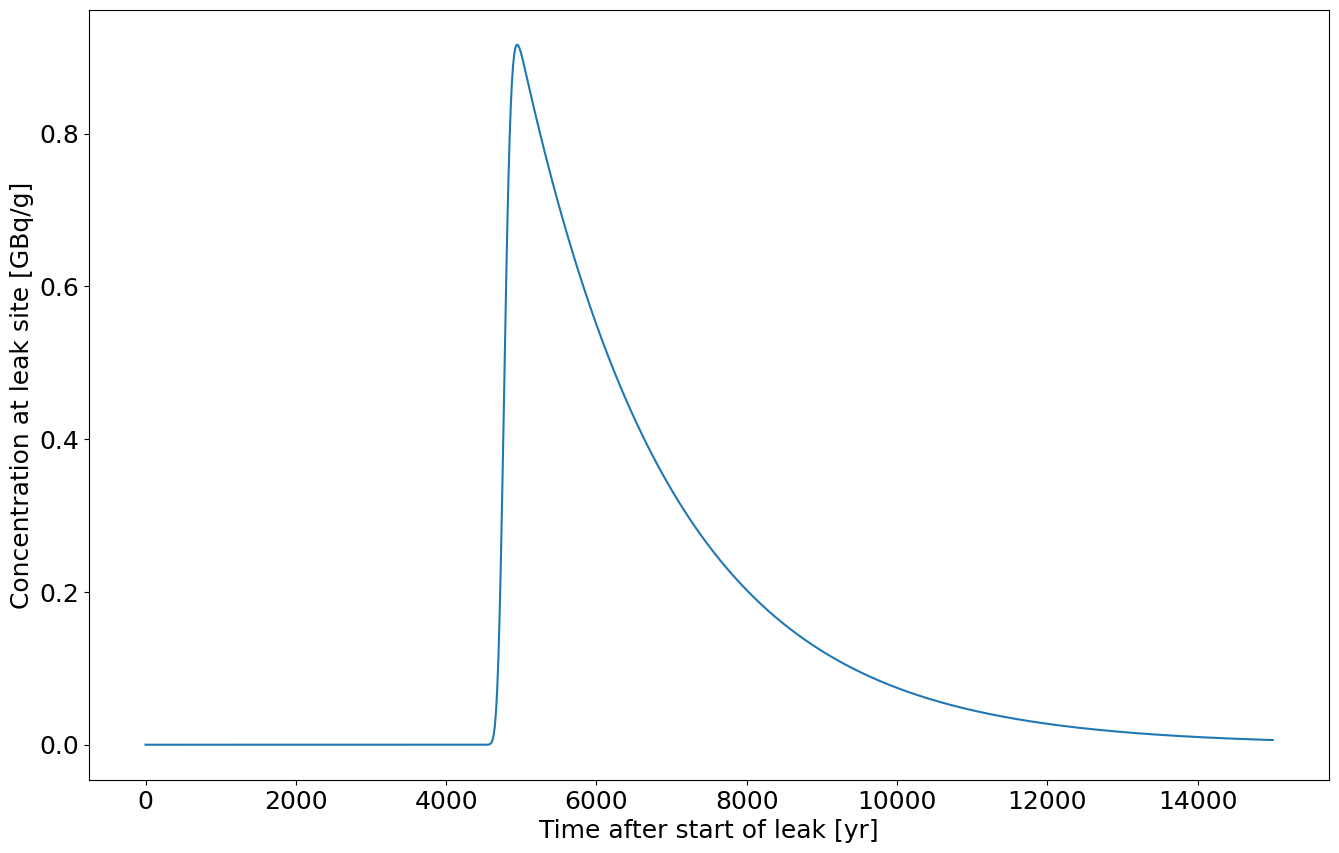

In [134]:
# Based on the AI suggested changes, the following code shows the breakthrough
# curve at location x = 1500m

plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})

desired_distance = 1500
distance_index = np.argmin(np.abs(x - desired_distance))
#print(distance_index)
plt.plot(t,C[distance_index, :])
#plt.title('Concentration of the contaminant over time')
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at leak site [GBq/g]')
plt.show()

# It aligns with the second graph. Concentration levels are bout 0.9 CBq/g